# Projet TER

In [13]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

import copy # To make a copy of a model


from torchvision import datasets, transforms
from torch.utils.data import random_split

from torchsummary import summary


import utils
from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
from utils.model import GenericNetwork
from utils.model import TeacherNetwork
from utils.model import StudentNetworkSmall
from utils.model import UNet_modular
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.model import ClassifNet
from utils.utils import getLossAccuracyOnDataset
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


"""
# If there are issues with the kernel, try the following :


python3 -m pip install ipykernel
python3 -m ipykernel install --user
"""

Random Seed:  999


'\n# If there are issues with the kernel, try the following :\n\n\npython3 -m pip install ipykernel\npython3 -m ipykernel install --user\n'

In [3]:
def load_model(model, path=""):
	if len(path)>0:
		state_dict = torch.load(path)
		model.load_state_dict(state_dict)
	model.to(device=device)

	if (device.type == 'cuda') and (ngpu > 1):
		print("Data Parallel")
		model = nn.DataParallel(model, list(range(ngpu)))
	
	return model


def load_student_model(path=""):
	# STUDENT
	return load_model(UNet_modular(channel_depth = 16, n_channels = 3, n_classes=3), path)


def load_teacher_model(path=""):
	# TEACHER
	return load_model(UNet_modular(channel_depth = 32, n_channels = 3, n_classes=3), path)

# Other

def save_model(model, path):
	torch.save(model.state_dict(), path)

# Function that returns a list of paths in a folder that start with a word
def get_path_list(path, start_with=""):
	path_list = [osp.join(path, f) for f in os.listdir(path) if f.startswith(start_with)]
	return path_list

# Function that returns the names in a path list with the last number in the name
def get_last_number_in_name(path_list):
	last_number = [int(f.split("_")[-1].split(".")[0]) for f in path_list]
	return last_number

def get_trainable_param(model):
	model_parameters = filter(lambda p: p.requires_grad, model.parameters())
	return sum([np.prod(p.size()) for p in model_parameters])


def show_prediction(model, val_loader, n=0):
	model.eval().cuda()

	criterion = nn.BCEWithLogitsLoss()
	with torch.no_grad():
		for i,(img,gt) in enumerate(val_loader):
			if n !=0 and i > n:
				break
		
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)

			# Plot image, output and ground truth one one row
			fig, ax = plt.subplots(1,3, figsize=(15,15))
			ax[0].imshow(img[0].cpu().numpy().transpose(1,2,0))
			ax[1].imshow(output[0].cpu().numpy().transpose(1,2,0))
			ax[2].imshow(gt[0].cpu().numpy().transpose(1,2,0))
			plt.show()
	

In [6]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
# Refaire nos data folder et tout pour que ce soit
# au format demandé par le dataloader

# Leave empty if you want to use the default name or load a previous session
session_name = ""

if len(session_name) == 0:
	session_name = "IGBMC_I3"+"_"+str(date)+"_"+str(heure)
	

dataset_folder = "/home/mehtali/TER_CNN_Compression/Data/training-data/data/IGBMC_I3_diversifie/patches/"
train_list = dataset_folder+"train_10000_i3.txt"
test_list = dataset_folder+"test_5000-7500_i3.txt"
validate_list = dataset_folder+"test_1000.txt"


# Number of workers for dataloader
workers = 10

# Batch size during training (low batch_size if there are memory issues)
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
learning_rate = 1e-5  # e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Saves every batch_save_interval
batch_save_interval = 2

# some net variable
amp = False

save_path =  "../Data/Saves/" + session_name
model_save_path = save_path+"/newtork_weigths/"

if not os.path.exists("../Data"):
	os.mkdir("../Data")
if not os.path.exists("../Data/Saves" ):
	os.mkdir("../Data/Saves" )

# We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
if not os.path.exists(save_path):
	os.mkdir(save_path)
	os.mkdir(save_path+"/loss-dice_listes")
	os.mkdir(save_path+"/newtork_weigths")
	os.mkdir(save_path+"/training_monitoring")

log_file = open(save_path+"/log+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("dataset_folder :"+dataset_folder+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_net="+str(learning_rate)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")
log_file.close()


In [14]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (
	torch.cuda.is_available() and ngpu > 0) else "cpu")

# On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("device ID", device)
print("nom du GPU", torch.cuda.get_device_name(device))  # On vérifie son "nom"

torch.cuda.empty_cache()


number of gpus : 4
device ID cuda:0
nom du GPU NVIDIA GeForce RTX 2080 Ti


images source :  torch.Size([10, 3, 256, 256])
mask source : torch.Size([10, 1, 256, 256])


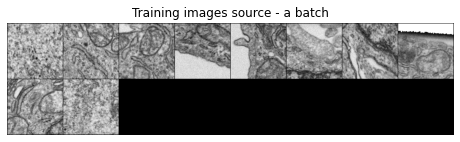

In [8]:
# For data augmentation

geometric_augs = [
	# transforms.Resize((256, 256)), # Makes it easier to process using net
	# transforms.RandomRotation(degrees=(0, 180)),
	transforms.RandomHorizontalFlip(),
	transforms.RandomVerticalFlip(),
	# transforms.RandomRotation(45),
]

color_augs = [
	# transforms.ColorJitter(hue=0.05, saturation=0.4)
]


def make_tfs(augs):
	return transforms.Compose([transforms.ToPILImage()]+augs + [transforms.ToTensor()])


tfs = transforms.Compose(geometric_augs)


# Importation des images et masques de i3
train_dataset = SegmentationDataSet(root=dataset_folder,
							  list_path=train_list,
							  #transform_img=make_tfs(
								#  geometric_augs + color_augs),
							  #transform_label=make_tfs(geometric_augs)
							  )

# Not a good idea to augment the test data
test_dataset = SegmentationDataSet(root=dataset_folder,
								list_path=test_list
								)
# Not a good idea to augment the test data
validate_dataset = SegmentationDataSet(root=dataset_folder,
								list_path=validate_list
								)



train_dataloader = torch.utils.data.DataLoader(train_dataset,
											   batch_size=batch_size,
											   shuffle=True,
											   num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
											  batch_size=batch_size,
											  shuffle=True,
											  num_workers=workers)

validation_dataloader = torch.utils.data.DataLoader(validate_dataset,
											  batch_size=batch_size,
											  shuffle=True,
											  num_workers=workers)


batch = next(iter(train_dataloader))

# On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
print("images source : ", batch[0].shape)
print("mask source :", batch[1].shape)



plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images source - a batch")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(
	device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# Neural net architecture

## Load or create neural net

In [10]:
# On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

teacher_summary = summary(load_teacher_model(), (3, 256, 256), verbose=0)

student_summary = summary(load_student_model(), (3, 256, 256), verbose=0)


log_file = open(save_path+"/model_architectures+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("Teacher network summary\n"+str(teacher_summary)+"\n\n")
log_file.write("Student network summary\n"+str(student_summary)+"\n")
log_file.close()

We are running U-Net on : NVIDIA GeForce RTX 2080 Ti


## Training

In [11]:
def evaluate(model, val_loader):
	model.eval().cuda()

	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with torch.no_grad():
		for i,(img,gt) in enumerate(val_loader):
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			loss = dice_loss(output, gt)
			dice = dice_coeff(output, gt)
			ll.append(loss.item())
			dl.append(dice.item())

	
	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)
	print("Eval metrics : dice {:.3f} and loss {:.3f}.".format(mean_dice, mean_loss))
	return mean_dice, mean_loss


def train(model, optimizer, train_loader):
	model.train().cuda()
	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
		for i, (img, gt) in enumerate(train_loader):
			#print('i', i)
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			
			img, gt = Variable(img), Variable(gt)

			output = model(img)
			output = output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)
			loss = dice_loss(output, gt)
			dice = dice_coeff(output, gt)
			ll.append(loss.item())
			dl.append(dice.item())

			
			optimizer.zero_grad()
			loss.backward()

			optimizer.step()

			pbar.update(len(img))
			pbar.set_postfix(**{'loss': loss.item(), "dice": dice.item()})
	
	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)

	print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

	return mean_dice, mean_loss


# Glbal teacher model
g_teacher_model = load_teacher_model()
T = 0.85  # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 1.0
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

def train_distilled(model, optimizer, train_loader):
	model.train().cuda()
	criterion = nn.BCEWithLogitsLoss()
	ll = []
	dl = []
	with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
		for i, (img, gt) in enumerate(train_loader):
			#print('i', i)
			if torch.cuda.is_available():
				img, gt = img.cuda(), gt.cuda()
			
			img, gt = Variable(img), Variable(gt)

			teacher_output = g_teacher_model(img)

			if torch.cuda.is_available():
				teacher_output = teacher_output.cuda()
			
			teacher_output =  Variable(teacher_output)



			student_output = model(img)
			student_output = student_output.clamp(min = 0, max = 1)
			gt = gt.clamp(min = 0, max = 1)

			student_output = student_output.clamp(min = 0, max = 1)
			teacher_output = teacher_output.clamp(min = 0, max = 1)

			student_loss = dice_loss(student_output, gt)
			# Try pixel-wise loss later on
			#kd_loss = dice_loss(student_output, teacher_output) #pixel_wise_loss(student_output, teacher_output)
			kd_loss = F.kl_div(F.log_softmax(student_output / T, dim=1), F.softmax(teacher_output / T, dim=1), reduction='batchmean')
			
			loss = kd_loss * alpha + student_loss * (1 - alpha)

			# Still calculate dice on student output and gt
			dice = dice_coeff(student_output, gt)

			ll.append(loss.item())
			dl.append(dice.item())

			
			optimizer.zero_grad()
			loss.backward()

			optimizer.step()

			pbar.update(len(img))
			pbar.set_postfix(**{'loss': loss.item(), "dice": dice.item()})
	
	mean_dice = np.mean(dl)
	mean_loss = np.mean(ll)

	print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

	return mean_dice, mean_loss

def model_training(model, train_loader, val_loader, trainFun, evalFun, n_epochs, name="model"):
	optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
	scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)

	former_best_dice = 0 # Worst possible
	former_best_loss = 1 # Worst possible
	early_stopping_streak = 0

	scheduled_saves = 0
	best_modem = model

	for epoch in range(n_epochs):
		print(' --- training: epoch {}'.format(epoch+1))

		# Train the model
		train_dice, train_loss = trainFun(model, optimizer, train_loader)

		# Modulate training rate
		scheduler.step()

		#evaluate for one epoch on validation set
		valid_dice, valid_loss = evalFun(model, val_loader)
		
		#if val_metric is best, add checkpoint
		if (epoch%5 == 0 or epoch==(n_epochs-1)):
			scheduled_saves+=1
		

		if former_best_dice < valid_dice:
			# dice is increasing
			early_stopping_streak = 0
			best_modem = copy.deepcopy(model)
			if scheduled_saves > 0:
				scheduled_saves -= 1
				save_model(model, model_save_path+name+"_dice_{:.3f}_loss_{:.3f}_epoch_{}.pth".format(valid_dice, valid_loss, epoch+1))
		else:
			# Is decresing
			early_stopping_streak += 1
			if early_stopping_streak >= 15:
				# 15 consecutive epochs without improvement in dice
				print("Early stopping at epoch {}".format(epoch+1))
				break
		
		former_best_dice = max(former_best_dice, valid_dice)
		former_best_loss = min(former_best_loss, valid_loss)
		
	return best_modem


In [12]:
# Training Function 
def train_deprecated(model, train_loader, validate_loader, trainStepFun, testStepFun, epochs=20):
	
	scheduler_params = dict(max_lr=1e-3,
							epochs=epochs, steps_per_epoch=len(train_loader))

	optimizer = optim.AdamW(list(model.parameters()))
	scheduler_global = optim.lr_scheduler.OneCycleLR(
		optimizer, **scheduler_params)  # goal: maximize Dice score
	grad_scaler_global = torch.cuda.amp.GradScaler(
		enabled=amp)  # Default parameter
	
	#best_accuracy = 0.0
	#interval = []
	#interval_count = 0
	#validation_accuracy_progression = []
	#validation_loss_progression = []
	for epoch in range(1, epochs+1):
		#running_train_loss = 0.0
		#running_accuracy = 0.0
		#running_vall_loss = 0.0
		#total = 0
		with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar_train:
			# Training Loop
			it = 0
			epoch_loss = 0
			epoch_acc = 0
			for i, (image, label) in enumerate(train_loader):
				print(i)

			for data in train_loader: 
				model.train()
				loss, acc = trainStepFun(model, (data["image"], data["label"]), optimizer)
				#running_train_loss += loss #  # track the loss value
				
				it+=1#data[0].shape[0]
				epoch_loss += loss
				epoch_acc += acc

				pbar_train.update(data[0].shape[0])
				pbar_train.set_postfix(**{'training loss (batch)': epoch_loss/it, "training accuracy (batch)": epoch_acc/it})
	
			# Calculate training loss value 
			#train_loss_value = running_train_loss/len(train_loader)

		
		with tqdm(total=len(validate_loader)*validate_loader.batch_size, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar_validate:
			# Validation Loop 
			it = 0
			epoch_loss = 0
			epoch_acc = 0
			with torch.no_grad(): # Why not ?
				for data in validate_loader:
					model.eval()
					## loss, acc = trainStepFun(model, data)
					loss, acc = testStepFun(model, data)

					# The label with the highest value will be our prediction 
					#running_vall_loss += loss
					#total += 1
					#running_accuracy += acc
					it+=1#data[0].shape[0]
					epoch_loss += loss
					epoch_acc += acc

					pbar_validate.update(data[0].shape[0])
					pbar_validate.set_postfix(**{'validation loss (batch)': epoch_loss/it, "validation accuracy (batch)": epoch_acc/it})
												
					#validation_accuracy_progression.append(acc)
					#validation_loss_progression.append(loss)
					#interval_count += 1
					#interval.append(interval_count)
	
		# Calculate validation loss value 
		#val_loss_value = running_vall_loss/len(validate_loader) 
				
		# Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
		#accuracy = (100.0 * running_accuracy / total)	 
 
		# Save the model if the accuracy is the best 
		#if accuracy > best_accuracy:
		#	torch.save(model.state_dict(), save_folder +
		#			   "/newtork_weigths/model_epoch{:}_validation_accuracy{:.3f}_train_loss{:.3f}.pth".format(epoch, accuracy, train_loss_value))
		#	best_accuracy = accuracy
		 
		# Print the statistics of the epoch 
		#print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value,
		#	   'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))
		"""
		validation_accuracy_smooth = smooth(validation_accuracy_progression, 0.99)
		validation_loss_smooth = smooth(validation_loss_progression, 0.99)

		plt.figure(1)
		plt.clf()
		plt.plot(interval, validation_accuracy_smooth,
				 'g-', label='Global accuracy')
		plt.xlabel("Iterations")
		plt.ylabel("Accuracy Value")
		plt.title("Accuracy Monitoring among validation")
		plt.legend()
		plt.savefig(save_folder+"/training_monitoring/accuracy_" +
					str(epoch)+"_epoch.png")
		
		if (epoch == epochs):
			plt.show()

		plt.figure(1)
		plt.clf()
		plt.plot(interval, validation_loss_smooth,
				 'r-', label='Global loss')
		plt.xlabel("Iterations")
		plt.ylabel("Loss Value")
		plt.title("Loss Monitoring among validation")
		plt.legend()
		plt.savefig(save_folder+"/training_monitoring/loss_" +
					str(epoch)+"_epoch.png")
		
		if (epoch == epochs):
			plt.show()
		"""

	# Return the fully trained model
	return model




In [ ]:
# Function to test the model
def test(model, test_loader, testStepFun):
	iter = 0
	epoch_loss = 0
	epoch_acc = 0
	with tqdm(total=len(test_loader)*test_loader.batch_size, desc=f'Testing', unit='img') as pbar_test:
		with torch.no_grad():
			for data in test_loader:
				loss, acc = testStepFun(model, data)

				iter += 1
				epoch_loss += loss
				epoch_acc += acc
				

				pbar_test.update(data[0].shape[0])
				pbar_test.set_postfix(**{'test loss': epoch_loss/iter, "test accuracy": epoch_acc/iter})
	return epoch_loss/iter , epoch_acc/iter

: 

In [ ]:
n_epochs = 50
n_models = 10

: 

In [ ]:
g_teacher_model = load_model(UNet_modular(channel_depth=32, n_channels=3, n_classes=1))
model_descr = "_model_parameters_{}".format(get_trainable_param(g_teacher_model))
g_teacher_model = model_training(g_teacher_model, train_dataloader, validation_dataloader, train, evaluate, 150, "teacher"+model_descr)
save_model(g_teacher_model, model_save_path+"best_teacher"+model_descr)

for i in range(1, n_models+1):
	model = load_model(UNet_modular(channel_depth=2*i, n_channels=3, n_classes=1))
	model_descr = "_model_{}_parameters_{}".format(i, get_trainable_param(model))
	nd_model = model_training(g_teacher_model, train_dataloader, validation_dataloader, train, evaluate, n_epochs, "not_distilled"+model_descr)
	save_model(nd_model, model_save_path+"best_not_distilled"+model_descr)
	
	d_model = model_training(g_teacher_model, train_dataloader, validation_dataloader, train_distilled, evaluate, n_epochs, "distilled_model"+model_descr)
	save_model(d_model, model_save_path+"best_distilled_model"+model_descr)

: 

In [ ]:
models_1 = [] 

models_2 = []


for i in range(30, n_models):
	  l1_size = int(1+i*1)
	  # Train models without distillation
	  model = train(load_model(GenericNetwork(l1_size)), train_dataloader, validation_dataloader, trainStep, testStep, n_epochs)
	  models_1.append(model)
	  save_model(model, save_path+"/newtork_weigths/no_distillation_first_layer_size_{:}.pth".format(l1_size))

	  model = train(load_model(GenericNetwork(l1_size)), train_dataloader, validation_dataloader, studentTrainStepDistillationMNIST, testStep, n_epochs)
	  models_2.append(model)
	  save_model(model, save_path+"/newtork_weigths/distillation_first_layer_size_{:}.pth".format(l1_size))


: 

# Testing

In [ ]:
# Tast a model
model = load_model(
    load_model(UNet_modular(channel_depth=32, n_channels=3, n_classes=1)),
    "/home/mehtali/TER_CNN_Compression/Data/Saves/IGBMC_I3_2023-03-15_17:51:47/newtork_weigths/best_teacher_model_parameters_3352257")

show_prediction(model, test_dataloader, 10)

: 

## Load multiple training sets

In [ ]:
n_training = 20

split = int(len(data)/n_training)
test_data_array = random_split(data, [split for i in range(n_training)])

print("Number of splits : ",len(test_data_array))
if len(test_data_array) > 0:
	print("Split size : ", len(test_data_array[0]))


: 

## Load models for testing

In [ ]:
not_distilled_model_paths = get_path_list(save_path+"/newtork_weigths", "no_distillation")
not_distilled_size = get_last_number_in_name(not_distilled_model_paths)

# Code to order model_paths and param by param in ascending order
not_distilled_model_paths = [x for _,x in sorted(zip(not_distilled_size,not_distilled_model_paths))]
not_distilled_size = sorted(not_distilled_size)

# Load the not distilled models in a list, initiating the GenericNetwork model with the correct size
not_distilled_models = []
for i in range(len(not_distilled_model_paths)):
	not_distilled_models.append(load_model(GenericNetwork(not_distilled_size[i]), not_distilled_model_paths[i]))

distilled_model_paths = get_path_list(save_path+"/newtork_weigths", "distillation")
distilled_size = get_last_number_in_name(distilled_model_paths)

# Code to order model_paths and param by param in ascending order
distilled_model_paths = [x for _,x in sorted(zip(distilled_size,distilled_model_paths))]
distilled_size = sorted(distilled_size)

# Load the distilled models in a list, initiating the GenericNetwork model with the correct size
distilled_models = []
for i in range(len(distilled_model_paths)):
	distilled_models.append(load_model(GenericNetwork(distilled_size[i]), distilled_model_paths[i]))


: 

In [ ]:
not_distilled_loss = []
not_distilled_accuracy = []
not_distilled_param = []

print("Testing models without distillation")
for i in range(0, len(not_distilled_models)):
	model = not_distilled_models[i]
	not_distilled_param.append(get_trainable_param(model))

	mean_loss = 0
	mean_acc = 0
	for data in test_data_array:
		test_dataloader = torch.utils.data.DataLoader(data,
											   batch_size=batch_size,
											   shuffle=True,
											   num_workers=workers)
		loss, acc = test(model, test_dataloader, testStep)
		mean_loss += loss
		mean_acc += acc
	
	mean_loss /= len(test_data_array)
	mean_acc /= len(test_data_array)

	not_distilled_loss.append(mean_loss)
	not_distilled_accuracy.append(mean_acc)



distilled_loss = []
distilled_accuracy = []
distilled_param = []

print("Testing models with distillation")
for i in range(0, len(distilled_models)):
	model = distilled_models[i]
	distilled_param.append(get_trainable_param(model))
	mean_loss = 0
	mean_acc = 0
	for data in test_data_array:
		test_dataloader = torch.utils.data.DataLoader(data,
											   batch_size=batch_size,
											   shuffle=True,
											   num_workers=workers)
		
		loss, acc = test(model, test_dataloader, testStep)
		mean_loss += loss
		mean_acc += acc
	
	mean_loss /= len(test_data_array)
	mean_acc /= len(test_data_array)

	distilled_loss.append(mean_loss)
	distilled_accuracy.append(mean_acc)


: 

# Plot data

In [ ]:
# PLOT ACCURACY

# Plot accuracy in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(not_distilled_param, not_distilled_accuracy,
			'g-', label='No distillation')
plt.plot(distilled_param, distilled_accuracy,
			'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy Value")
plt.title("Accuracy Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/accuracy_param.png")
plt.show()



# Plot the gain in accuracy in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(distilled_param, np.array(distilled_accuracy)-np.array(not_distilled_accuracy),
			'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy Value")
plt.title("Accuracy Gain Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/accuracy_gain_param.png")
plt.show()



# PLOT LOSS

# Plot loss in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(not_distilled_param, not_distilled_loss,
			'g-', label='No distillation')
plt.plot(distilled_param, distilled_loss,
			'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/loss_param.png")
plt.show()


# Plot the gain in loss in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(distilled_param, np.array(not_distilled_loss)-np.array(distilled_loss),
			'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Gain Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/loss_gain_param.png")
plt.show()

log_file = open(save_path+"/training_monitoring/raw_data"+session_name+".txt", "w")
log_file.write("Not distilled data\n")
log_file.write("number of param : " + str(not_distilled_param) + "\n")
log_file.write("accuracy : " + str(not_distilled_accuracy) + "\n")
log_file.write("loss : " + str(not_distilled_loss) + "\n")


log_file.write("Distilled data\n")
log_file.write("number of param : " + str(distilled_param) + "\n")
log_file.write("accuracy : " + str(distilled_accuracy) + "\n")
log_file.write("loss : " + str(distilled_loss) + "\n")


log_file.close()


: 

In [ ]:
print(not_distilled_param)
print(not_distilled_accuracy)
print(not_distilled_loss)

print(distilled_param)
print(distilled_accuracy)
print(distilled_loss)

: 

In [ ]:
"""global_step =  0
n_train = len(filtered_train_data)
print(n_train)

T = 1.0 # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 1.0
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

print("Starting Training Loop...")


source_dice = []
intervalle = []

L_seg_list = []

loss_list = []
acc_list = []

L_s_list = []

compteur_plot = 0

for epoch in range(num_epochs):
	epoch_loss = 0
	epoch_acc = 0
	cpt_it = 0
	with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='img') as pbar:

		for i, data in enumerate(filtered_train_dataloader, 0):
			student_model.train()
			teacher_model.eval()

			cpt_it += 1

			X, y = data

			X = X.to(
				device=device, dtype=torch.float32)
			y = y.to(
				device=device, dtype=torch.long)

			# Pass Data Trought net before optimizing everything

			loss, acc = studentTrainStep(teacher_model, student_model, studentLoss, optimizer_global, X, y, T, alpha)
			

			L_global = loss

			###########################################################
			# Evaluation on the Training Set
			###########################################################

			student_model.eval()

			intervalle.append(compteur_plot)
			compteur_plot += 1

			global_step += 1
			epoch_loss += loss.item()
			epoch_acc += acc

			pbar.update(X.shape[0])
			pbar.set_postfix(
				**{'loss (batch)': epoch_loss/cpt_it, "accuracy (batch)": epoch_acc/cpt_it})
			# pbar.set_postfix(**{'dice target': dice_target})

			loss_list.append(loss.item())
			acc_list.append(acc)
# print("whole epoch target dice mean :", sum(dice_score_target)/cpt_it)
		if (epoch % batch_save_interval == 0):  # and epoch != 0 :

			loss_smooth = smooth(loss_list, 0.99)
			acc_smooth = smooth(acc_list, 0.99)

			torch.save(student_model.state_dict(), saving_folder +
					   "/newtork_weigths/net_epoch{:}_acc{:.3f}_loss{:.3f}.pth".format(epoch, epoch_acc/cpt_it, epoch_loss/cpt_it))

			plt.figure(1)
			plt.clf()
			plt.plot(intervalle, acc_smooth, 'r-', label='Global accuracy')
			plt.xlabel("iterations")
			plt.ylabel("Accuracy Value")
			plt.title("Accuracy Monitoring among training")
			plt.legend()
			plt.savefig(saving_folder+"/training_monitoring/acc_" +
						str(epoch)+"_epoch.png")
			plt.show()

			plt.figure(1)
			plt.clf()
			plt.plot(intervalle, loss_smooth, 'r-', label='Global loss')
			plt.xlabel("iterations")
			plt.ylabel("Loss Value")
			plt.title("Loss Monitoring among training")
			plt.legend()
			plt.savefig(saving_folder+"/training_monitoring/loss_" +
						str(epoch)+"_epoch.png")
			plt.show()"""


: 